In [1]:
# --- INSTALLS ---
# Kaggle usually has these, but good to ensure versions
!pip install -q scikit-learn==1.5.2
!pip install -q nltk==3.9.1 tqdm==4.66.5
!pip install -q lightgbm==4.5.0

# --- IMPORTS ---
import os, re, string, pickle, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import lightgbm as lgb # <--- CHANGED TO LIGHTGBM

from tqdm import tqdm
from pprint import pprint

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve, auc,
                             average_precision_score, precision_recall_curve)
from sklearn.utils.class_weight import compute_class_weight

from scipy import sparse

# --- TEXT PREP (NLTK) ---\
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

# --- TF-IDF ---
from sklearn.feature_extraction.text import TfidfVectorizer

# --- PLOTTING ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.dpi"] = 130

RNG = 42
N_CLASSES = 3

# --- PATHS (KAGGLE SPECIFIC) ---
# IMPORTANT: Update 'your-dataset-name' to the actual folder name in Kaggle inputs
# It usually looks like: /kaggle/input/movie-reviews-dataset/Composite2_194k data.csv
CSV_PATH = "/kaggle/input/ml-194kc2-3/Composite2_194k data.csv" 
BASE_SAVE_DIR = "/kaggle/working/LightGBM_Multiclass"
os.makedirs(BASE_SAVE_DIR, exist_ok=True)

# --- LOAD ---
# Check if file exists to prevent crash
if not os.path.exists(CSV_PATH):
    print(f"WARNING: File not found at {CSV_PATH}. Please check your Kaggle Input path.")
else:
    df = pd.read_csv(CSV_PATH)

    # --- BASIC CLEANING (MULTICLASS VERSION) ---
    need = ['title','reviewText','target_label','tomatoMeter','genre','audienceScore',
            'runtimeMinutes','language_encoded','director_encoded']
    missing = [c for c in need if c not in df.columns]
    
    if not missing:
        # Drop rows with missing target or review text
        df = df.dropna(subset=['reviewText','target_label']).copy()
        df['label'] = df['target_label'].astype(int)

        # Verify we have 3 classes: 0 (Negative), 1 (Neutral), 2 (Positive)
        assert df['label'].isin([0, 1, 2]).all(), "Labels must be 0, 1, or 2"

        # Keep only needed columns
        df['title'] = df['title'].fillna("")
        df['genre'] = df['genre'].fillna("Unknown")

        class_names = ['Negative', 'Neutral', 'Positive']
        print("Rows:", len(df))
        print("Class distribution:")
        print(df['label'].value_counts().sort_index())
        print("\nClass proportions:")
        print(df['label'].value_counts(normalize=True).sort_index().round(4))

# --- TEXT PREPROCESSING ---
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    s = s.lower()
    # contractions (quick pass)
    s = re.sub(r"'", "'", s)
    s = re.sub(r"n't\b", " not", s)
    s = re.sub(r"'re\b", " are", s)
    s = re.sub(r"'s\b", " is", s)
    s = re.sub(r"'d\b", " would", s)
    s = re.sub(r"'ll\b", " will", s)
    s = re.sub(r"'ve\b", " have", s)
    s = re.sub(r"'m\b", " am", s)
    # remove urls/emails/handles
    s = re.sub(r"http\S+|www\.\S+|[\w\.-]+@[\w\.-]+", " ", s)
    # keep letters only
    s = re.sub(r"[^a-z\s]", " ", s)
    # tokenize → remove stopwords → lemmatize → (light) stem
    tokens = [w for w in word_tokenize(s) if w not in STOPWORDS and len(w) > 2]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]
    stems  = [stemmer.stem(w) for w in lemmas]
    return " ".join(stems)

def fit_tfidf(train_texts, max_features=50000, ngram_range=(1,2), min_df=3):
    vec = TfidfVectorizer(
        preprocessor=None,
        tokenizer=None,
        analyzer='word',
        ngram_range=ngram_range,
        min_df=min_df,
        max_features=max_features,
        lowercase=False,
        dtype=np.float32
    )
    X = vec.fit_transform(train_texts)
    return vec, X

def transform_tfidf(vec, texts):
    return vec.transform(texts)

print("\n✅ Part 1 Complete: Data loaded and preprocessing functions defined.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
preprocessing 0.1.13 requires nlt

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


Rows: 194784
Class distribution:
label
0    55029
1    66081
2    73674
Name: count, dtype: int64

Class proportions:
label
0    0.2825
1    0.3393
2    0.3782
Name: proportion, dtype: float64

✅ Part 1 Complete: Data loaded and preprocessing functions defined.


In [2]:
# --- MULTICLASS FEATURE ENGINEERING ---

NUM_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']

# =======================================================
# MULTICLASS DIRECTOR BLOCKS (Target Encoding)
# =======================================================
def director_blocks_multiclass(train_s: pd.Series, y: np.ndarray, test_s: pd.Series, n_splits: int = 5):
    """
    Multiclass Target Encoding: Calculates mean for each class (0, 1, 2)
    Returns 1 freq col + 3 target mean cols (4 total features per director).
    """
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # 1. Frequency features (log1p)
    freq = s_train.value_counts()
    tr_freq = np.log1p(s_train.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)
    te_freq = np.log1p(s_test.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)

    # 2. Multiclass Target mean encoding (leak-safe OOF)
    y_ohe = OneHotEncoder(categories=[range(N_CLASSES)], sparse_output=False, dtype=np.float32).fit_transform(y.reshape(-1, 1))
    global_mean = y_ohe.mean(axis=0)

    tr_te = np.zeros((len(s_train), N_CLASSES), dtype=np.float32)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)

    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_fold = s_train.iloc[tr_i]
        fold_means = pd.DataFrame(y_ohe[tr_i], index=tr_fold.index).groupby(tr_fold).mean()

        val_fold = s_train.iloc[val_i].to_frame(name='did')
        merged = val_fold.merge(fold_means, left_on='did', right_index=True, how='left')
        vals = merged.drop('did', axis=1).values

        mask = np.isnan(vals.sum(axis=1))
        vals[mask] = global_mean
        tr_te[val_i] = vals.astype(np.float32)

    # Test set mapping (using full train)
    full_means = pd.DataFrame(y_ohe, index=s_train.index).groupby(s_train).mean()
    test_df_map = s_test.to_frame(name='did')
    merged_test = test_df_map.merge(full_means, left_on='did', right_index=True, how='left')
    te_te = merged_test.drop('did', axis=1).values

    mask_test = np.isnan(te_te.sum(axis=1))
    te_te[mask_test] = global_mean

    return tr_freq, te_freq, tr_te, te_te

# =======================================================
# GENRE & LANGUAGE ENCODINGS
# =======================================================
def fit_categoricals(train_genre, train_lang):
    mlb = MultiLabelBinarizer()
    G = mlb.fit_transform(train_genre)

    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True, dtype=np.float32)
    L = ohe.fit_transform(train_lang.to_frame(name="lang"))
    return mlb, ohe, G, L

def transform_categoricals(mlb, ohe, genre_series, lang_series):
    G = mlb.transform(genre_series)
    L = ohe.transform(lang_series.to_frame(name="lang"))
    return G, L

# =======================================================
# NUMERICS: scale on TRAIN only
# =======================================================
def fit_scale_numeric(train_df, cols):
    scaler = StandardScaler()
    X = scaler.fit_transform(train_df[cols].fillna(train_df[cols].median()))
    return scaler, X

def transform_scale_numeric(scaler, df, cols):
    return scaler.transform(df[cols].fillna(df[cols].median()))

# =======================================================
# TRAIN/TEST SPLIT (Stratified by 3 classes)
# =======================================================
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=RNG, stratify=df['label']
)
y_train = train_df['label'].values
y_test = test_df['label'].values

print(f"\nTrain size: {len(train_df)} | Test size: {len(test_df)}")
print("Train class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nTest class distribution:")
print(pd.Series(y_test).value_counts().sort_index())

# =======================================================
# COMPUTE CLASS WEIGHTS (for imbalanced 3-class data)
# =======================================================
class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
print(f"\nClass weights: {class_weight_dict}")

print("\n✅ Part 2 Complete: Feature engineering functions and train/test split ready.")


Train size: 155827 | Test size: 38957
Train class distribution:
0    44023
1    52865
2    58939
Name: count, dtype: int64

Test class distribution:
0    11006
1    13216
2    14735
Name: count, dtype: int64

Class weights: {0: 1.1798908146499179, 1: 0.9825467385478736, 2: 0.8812896949953907}

✅ Part 2 Complete: Feature engineering functions and train/test split ready.


In [3]:
# =======================================================
# MULTICLASS EVALUATION & PLOTTING (4-DECIMAL PRECISION)
# =======================================================

def evaluate_and_plot(model_name, setup_name, y_true, y_prob, y_pred, save_dir, class_names=['Negative', 'Neutral', 'Positive']):
    """
    Multiclass evaluation with 4-decimal precision.
    """
    os.makedirs(save_dir, exist_ok=True)
    n_classes = len(class_names)

    # Calculate metrics with weighted average (for imbalanced data)
    acc  = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n[{setup_name} | {model_name}]")
    print(f"Accuracy={acc:.4f}  F1_weighted={f1:.4f}  Precision_weighted={pr:.4f}  Recall_weighted={rc:.4f}")

    # ⭐ 4-DECIMAL CLASSIFICATION REPORT
    print("\n--- Classification Report (4 Decimal Places) ---")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0, digits=4)
    print(report)

    # ⭐ CONFUSION MATRIX (Counts + Normalized with 4 decimals)
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 5))

    # Counts (Integers)
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{setup_name} | {model_name}\nConfusion Matrix (Counts)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # ⭐ 4-DECIMAL NORMALIZED CONFUSION MATRIX
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{setup_name} | {model_name}\nConfusion Matrix (Normalized, 4-Decimals)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_{setup_name}_confusion.png'), dpi=130, bbox_inches='tight')
    plt.show()

    # Per-class metrics
    pr_per_class, rc_per_class, f1_per_class, support = precision_recall_fscore_support(
        y_true, y_pred, labels=range(n_classes), zero_division=0
    )

    print("\n--- Per-Class Metrics (4 Decimals) ---")
    for i, cname in enumerate(class_names):
        print(f"{cname:10s}: Precision={pr_per_class[i]:.4f}  Recall={rc_per_class[i]:.4f}  F1={f1_per_class[i]:.4f}  Support={support[i]}")

    return {
        "accuracy": acc,
        "f1_weighted": f1,
        "precision_weighted": pr,
        "recall_weighted": rc,
        "per_class_precision": pr_per_class,
        "per_class_recall": rc_per_class,
        "per_class_f1": f1_per_class
    }

print("\n✅ Part 3 Complete: Multiclass evaluation helpers ready (4-decimal precision).")


✅ Part 3 Complete: Multiclass evaluation helpers ready (4-decimal precision).


In [4]:
# =======================================================
# BUILD ALL FEATURE MATRICES (8 Features: Review + Title + Num + Genre + Lang + Director)
# =======================================================

print("--- Building ALL Features Matrix ---")

# ---- TEXT FEATURES ----
# 1. Review Text
train_review = train_df['reviewText'].map(clean_text)
test_review  = test_df['reviewText'].map(clean_text)
tfidf_review, Xtr_review = fit_tfidf(train_review, max_features=60000, ngram_range=(1,2), min_df=3)
Xte_review = transform_tfidf(tfidf_review, test_review)

# 2. Title Text
train_title = train_df['title'].map(clean_text)
test_title  = test_df['title'].map(clean_text)
tfidf_title, Xtr_title = fit_tfidf(train_title, max_features=30000, ngram_range=(1,2), min_df=3)
Xte_title = transform_tfidf(tfidf_title, test_title)

# ---- NUMERIC FEATURES ----
scaler_all, Xtr_num_np = fit_scale_numeric(train_df, NUM_COLS)
Xte_num_np = transform_scale_numeric(scaler_all, test_df, NUM_COLS)
Xtr_num = sparse.csr_matrix(Xtr_num_np.astype(np.float32))
Xte_num = sparse.csr_matrix(Xte_num_np.astype(np.float32))

# ---- CATEGORICAL FEATURES ----
# Genre (multi-label)
train_genre = train_df['genre'].fillna("Unknown").str.split(', ')
test_genre  = test_df['genre'].fillna("Unknown").str.split(', ')

# Language (single label)
train_lang  = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')
test_lang   = test_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

mlb_all, ohe_all, Xtr_genre, Xtr_lang = fit_categoricals(train_genre, train_lang)
Xte_genre, Xte_lang = transform_categoricals(mlb_all, ohe_all, test_genre, test_lang)

Xtr_genre = sparse.csr_matrix(Xtr_genre.astype(np.float32))
Xte_genre = sparse.csr_matrix(Xte_genre.astype(np.float32))

# ---- DIRECTOR FEATURES (Multiclass Target Encoding) ----
tr_f, te_f, tr_te, te_te = director_blocks_multiclass(
    train_df['director_encoded'], y_train, test_df['director_encoded']
)
Xtr_dir = sparse.csr_matrix(np.concatenate([tr_f, tr_te], axis=1).astype(np.float32))
Xte_dir = sparse.csr_matrix(np.concatenate([te_f, te_te], axis=1).astype(np.float32))

# ---- STACK ALL FEATURES ----
X_train_ALL = sparse.hstack([Xtr_review, Xtr_title, Xtr_num, Xtr_genre, Xtr_lang, Xtr_dir], format='csr')
X_test_ALL  = sparse.hstack([Xte_review, Xte_title, Xte_num, Xte_genre, Xte_lang, Xte_dir], format='csr')

print("\n--- Feature Matrix Stacking Complete ---")
print(f"X_train_ALL shape: {X_train_ALL.shape}")
print(f"X_test_ALL shape:  {X_test_ALL.shape}")
print(f"Features include: Review TF-IDF, Title TF-IDF, Numerics, Genre, Language, Director (Total: {X_train_ALL.shape[1]} features)")

print("\n✅ Part 4 Complete: ALL features matrix ready.")

--- Building ALL Features Matrix ---

--- Feature Matrix Stacking Complete ---
X_train_ALL shape: (155827, 83942)
X_test_ALL shape:  (38957, 83942)
Features include: Review TF-IDF, Title TF-IDF, Numerics, Genre, Language, Director (Total: 83942 features)

✅ Part 4 Complete: ALL features matrix ready.



LIGHTGBM — REVIEW TEXT ONLY
X_train_REVIEW shape: (155827, 60000)
X_test_REVIEW shape: (38957, 60000)
Creating LightGBM Datasets...

Running 5-Fold Cross-Validation...
  Fold 1: acc=0.5708 | f1_weighted=0.5676
  Fold 2: acc=0.5674 | f1_weighted=0.5645
  Fold 3: acc=0.5704 | f1_weighted=0.5673
  Fold 4: acc=0.5700 | f1_weighted=0.5671
  Fold 5: acc=0.5700 | f1_weighted=0.5667
  LightGBM (Review Text Only) CV mean±std | acc=0.5697±0.0012 f1_w=0.5666±0.0011

Training on full training set...
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.971239	test's multi_logloss: 0.989418
[200]	train's multi_logloss: 0.925082	test's multi_logloss: 0.956695
[300]	train's multi_logloss: 0.894749	test's multi_logloss: 0.937087
[400]	train's multi_logloss: 0.871192	test's multi_logloss: 0.923488
[500]	train's multi_logloss: 0.851792	test's multi_logloss: 0.91331
[600]	train's multi_logloss: 0.835577	test's multi_logloss: 0.905756
[700]	train's multi_logloss: 0.8

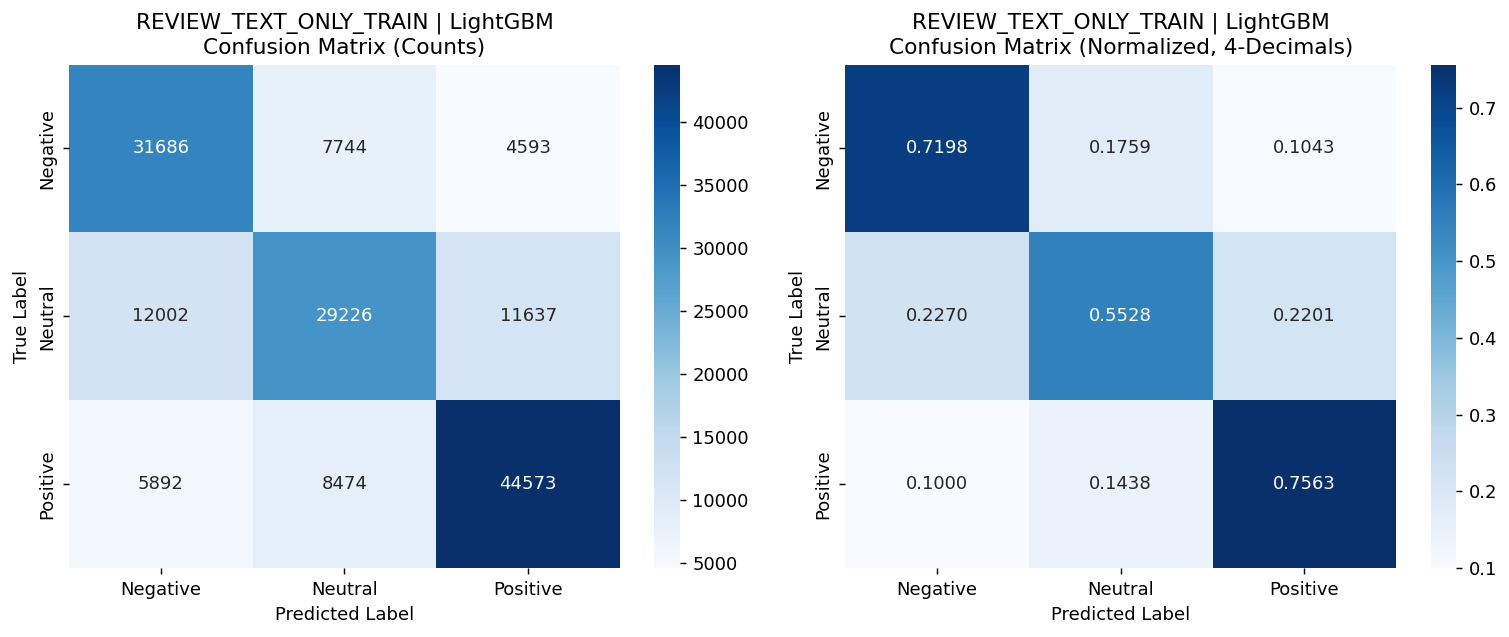


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6391  Recall=0.7198  F1=0.6770  Support=44023
Neutral   : Precision=0.6431  Recall=0.5528  F1=0.5946  Support=52865
Positive  : Precision=0.7331  Recall=0.7563  F1=0.7445  Support=58939

TEST SET PERFORMANCE

[REVIEW_TEXT_ONLY_TEST | LightGBM]
Accuracy=0.5759  F1_weighted=0.5728  Precision_weighted=0.5725  Recall_weighted=0.5759

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.5405    0.6079    0.5722     11006
     Neutral     0.4928    0.4275    0.4578     13216
    Positive     0.6680    0.6850    0.6764     14735

    accuracy                         0.5759     38957
   macro avg     0.5671    0.5735    0.5688     38957
weighted avg     0.5725    0.5759    0.5728     38957



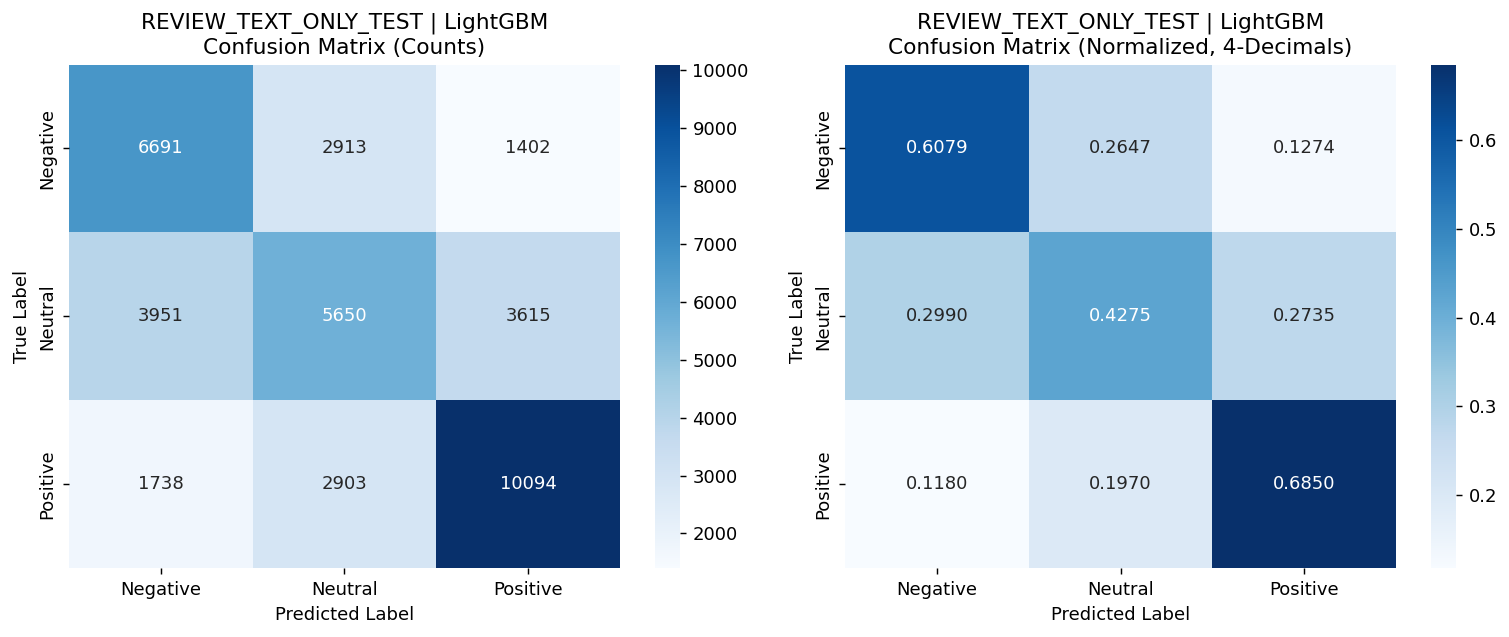


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.5405  Recall=0.6079  F1=0.5722  Support=11006
Neutral   : Precision=0.4928  Recall=0.4275  F1=0.4578  Support=13216
Positive  : Precision=0.6680  Recall=0.6850  F1=0.6764  Support=14735

✅ Model saved to: /kaggle/working/LightGBM_Multiclass/REVIEW_TEXT_ONLY/LightGBM_REVIEW_Multiclass.pkl


In [5]:
# ======================================================================
# LIGHTGBM — REVIEW TEXT ONLY (Review Text TF-IDF)
# ======================================================================

setup = "REVIEW_TEXT_ONLY"
save_dir = os.path.join(BASE_SAVE_DIR, setup)
os.makedirs(save_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"LIGHTGBM — REVIEW TEXT ONLY")
print(f"{'='*70}")

# ---- DEFINING PARAMS LOCALLY (So this cell is independent) ----
lgb_params_review = {
    'objective': 'multiclass',
    'num_class': N_CLASSES,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    
    # Model Complexity
    'max_depth': 8,
    'num_leaves': 128,  
    'learning_rate': 0.1,
    
    # Regularization & Sampling
    'bagging_fraction': 0.8, # subsample
    'bagging_freq': 1,
    'feature_fraction': 0.8, # colsample_bytree
    'min_child_weight': 5,
    'lambda_l1': 0.1, # reg_alpha
    'lambda_l2': 1.0, # reg_lambda
    
    # SWITCH TO CPU FOR STABILITY WITH SPARSE DATA
    'device': 'cpu', 
    'n_jobs': -1,  # Use all available Kaggle CPU cores
    
    'seed': RNG,
    'verbose': -1
}

# Use only review text features
# We assume Xtr_review and Xte_review exist from Part 4
X_train_REVIEW = Xtr_review
X_test_REVIEW = Xte_review

print(f"X_train_REVIEW shape: {X_train_REVIEW.shape}")
print(f"X_test_REVIEW shape: {X_test_REVIEW.shape}")

# Create LightGBM Dataset
print("Creating LightGBM Datasets...")
sample_weights_train = np.array([class_weight_dict[label] for label in y_train])
train_data_review = lgb.Dataset(X_train_REVIEW, label=y_train, weight=sample_weights_train)
test_data_review = lgb.Dataset(X_test_REVIEW, label=y_test, reference=train_data_review)

# ---- K-FOLD CROSS-VALIDATION ----
print("\nRunning 5-Fold Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
cv_scores_review = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_REVIEW, y_train), 1):
    X_tr_fold = X_train_REVIEW[tr_idx]
    X_val_fold = X_train_REVIEW[val_idx]
    y_tr_fold = y_train[tr_idx]
    y_val_fold = y_train[val_idx]
    
    w_tr_fold = np.array([class_weight_dict[label] for label in y_tr_fold])
    
    dtrain_fold = lgb.Dataset(X_tr_fold, label=y_tr_fold, weight=w_tr_fold)
    dval_fold = lgb.Dataset(X_val_fold, label=y_val_fold, reference=dtrain_fold)
    
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=0) # Silence per-fold logs
    ]
    
    model_fold = lgb.train(
        lgb_params_review, # Using local independent params
        dtrain_fold,
        num_boost_round=1000,
        valid_sets=[dtrain_fold, dval_fold],
        callbacks=callbacks
    )
    
    # Predict
    y_pred_prob_fold = model_fold.predict(X_val_fold)
    y_pred_fold = np.argmax(y_pred_prob_fold, axis=1)
    
    acc = accuracy_score(y_val_fold, y_pred_fold)
    f1 = precision_recall_fscore_support(y_val_fold, y_pred_fold, average='weighted', zero_division=0)[2]
    cv_scores_review.append((acc, f1))
    print(f"  Fold {fold}: acc={acc:.4f} | f1_weighted={f1:.4f}")

cv_arr_review = np.array(cv_scores_review)
print(f"  LightGBM (Review Text Only) CV mean±std | acc={cv_arr_review[:,0].mean():.4f}±{cv_arr_review[:,0].std():.4f} f1_w={cv_arr_review[:,1].mean():.4f}±{cv_arr_review[:,1].std():.4f}")

# ---- FIT ON FULL TRAIN ----
print("\nTraining on full training set...")
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100)
]

lgb_review = lgb.train(
    lgb_params_review, 
    train_data_review, 
    num_boost_round=1000, 
    valid_sets=[train_data_review, test_data_review], 
    valid_names=['train', 'test'], 
    callbacks=callbacks
)

# ---- PREDICTIONS ----
print("\nMaking predictions...")
train_prob_review = lgb_review.predict(X_train_REVIEW)
train_pred_review = np.argmax(train_prob_review, axis=1)

test_prob_review = lgb_review.predict(X_test_REVIEW)
test_pred_review = np.argmax(test_prob_review, axis=1)

# ---- EVALUATION ----
print(f"\n{'='*70}")
print("TRAIN SET PERFORMANCE")
print(f"{'='*70}")
train_metrics_review = evaluate_and_plot(
    "LightGBM", f"{setup}_TRAIN", y_train, train_prob_review, train_pred_review, save_dir
)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE")
print(f"{'='*70}")
test_metrics_review = evaluate_and_plot(
    "LightGBM", f"{setup}_TEST", y_test, test_prob_review, test_pred_review, save_dir
)

# ---- SAVE MODEL ----
model_path_review = os.path.join(save_dir, "LightGBM_REVIEW_Multiclass.pkl")
with open(model_path_review, "wb") as f:
    pickle.dump({
        "model": lgb_review,
        "tfidf_review": tfidf_review,
        "class_names": class_names,
        "class_weight_dict": class_weight_dict,
        "lgb_params": lgb_params_review,
        "feature_set": "Review Text Only"
    }, f)

print(f"\n✅ Model saved to: {model_path_review}")


LIGHTGBM — REVIEW TEXT ONLY
X_train_REVIEW shape: (155827, 60000)
X_test_REVIEW shape: (38957, 60000)
Creating LightGBM Datasets...

Running 5-Fold Cross-Validation...
  Fold 1: acc=0.5684 | f1_weighted=0.5654
  Fold 2: acc=0.5630 | f1_weighted=0.5598
  Fold 3: acc=0.5635 | f1_weighted=0.5600
  Fold 4: acc=0.5642 | f1_weighted=0.5608
  Fold 5: acc=0.5649 | f1_weighted=0.5613
  LightGBM (Review Text Only) CV mean±std | acc=0.5648±0.0019 f1_w=0.5614±0.0020

Training on full training set...
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 1.00228	test's multi_logloss: 1.01035
[200]	train's multi_logloss: 0.964294	test's multi_logloss: 0.979876
[300]	train's multi_logloss: 0.938741	test's multi_logloss: 0.960816
[400]	train's multi_logloss: 0.91874	test's multi_logloss: 0.946569
[500]	train's multi_logloss: 0.902302	test's multi_logloss: 0.935657
[600]	train's multi_logloss: 0.888465	test's multi_logloss: 0.926801
[700]	train's multi_logloss: 0.876

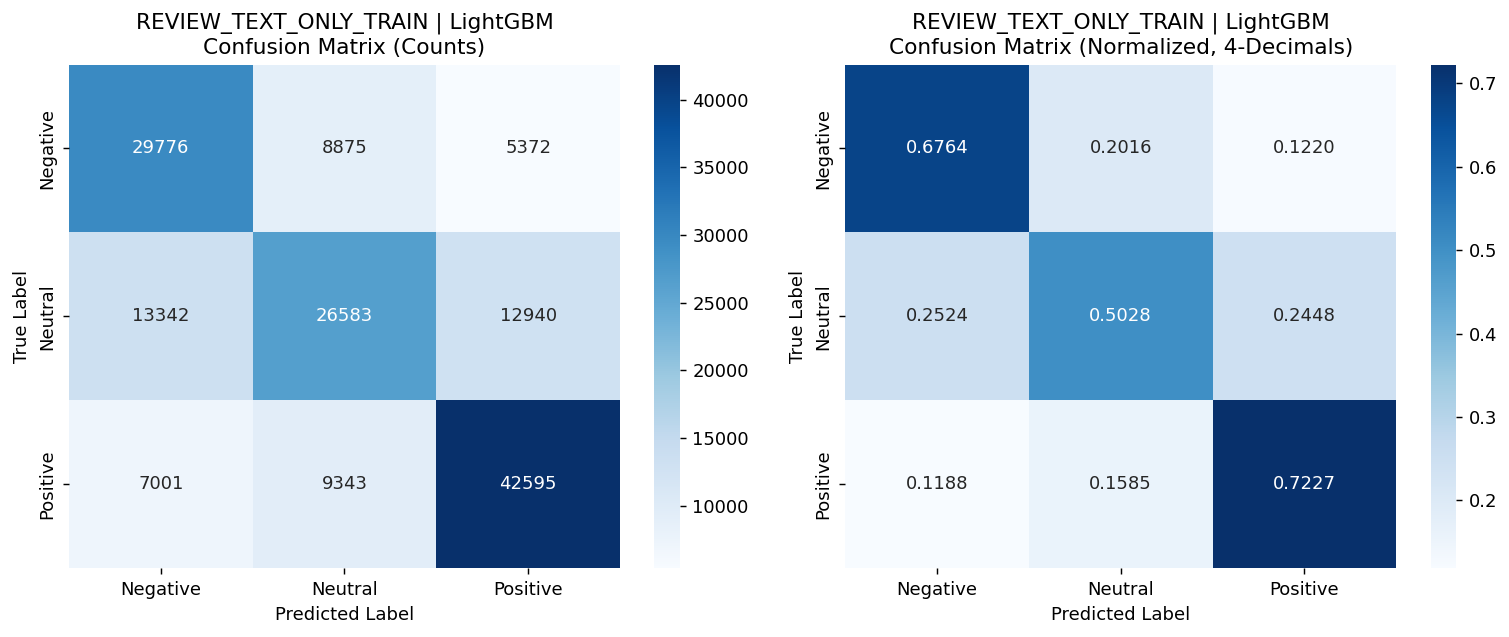


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.5941  Recall=0.6764  F1=0.6326  Support=44023
Neutral   : Precision=0.5934  Recall=0.5028  F1=0.5444  Support=52865
Positive  : Precision=0.6993  Recall=0.7227  F1=0.7108  Support=58939

TEST SET PERFORMANCE

[REVIEW_TEXT_ONLY_TEST | LightGBM]
Accuracy=0.5728  F1_weighted=0.5698  Precision_weighted=0.5700  Recall_weighted=0.5728

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.5346    0.6099    0.5698     11006
     Neutral     0.4956    0.4258    0.4581     13216
    Positive     0.6631    0.6770    0.6700     14735

    accuracy                         0.5728     38957
   macro avg     0.5644    0.5709    0.5659     38957
weighted avg     0.5700    0.5728    0.5698     38957



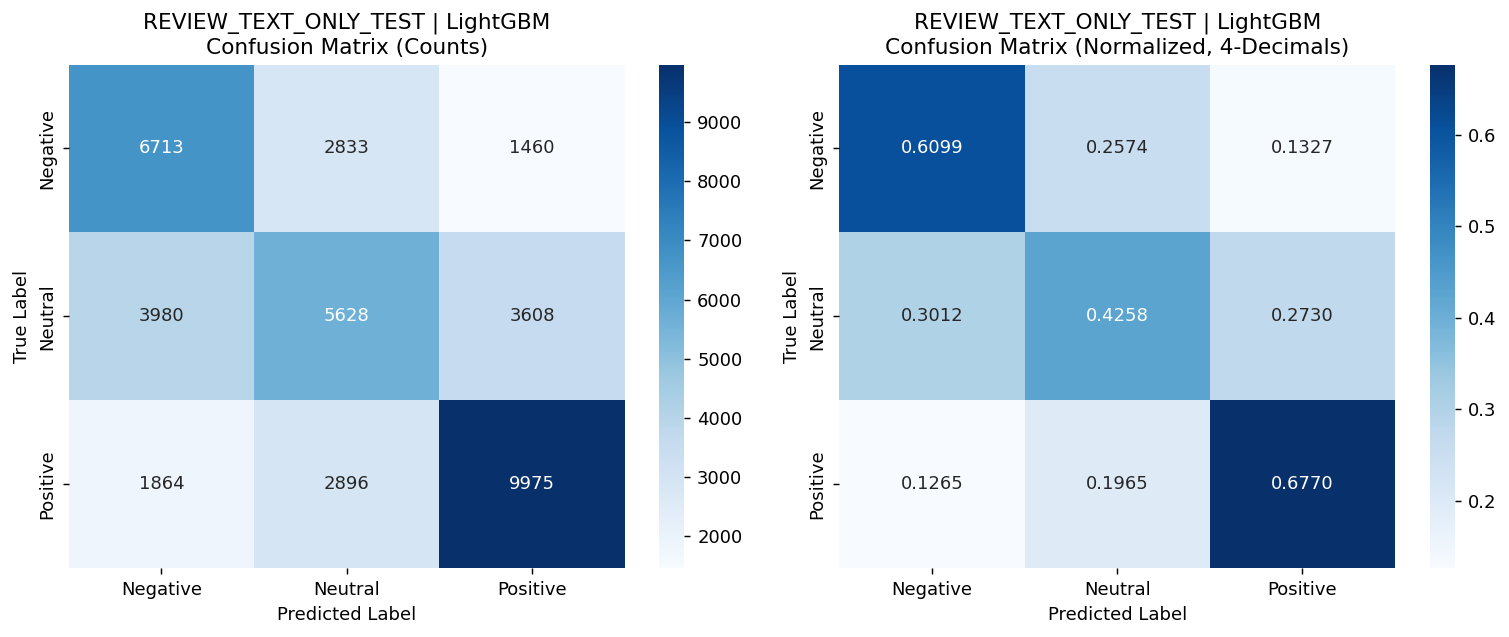


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.5346  Recall=0.6099  F1=0.5698  Support=11006
Neutral   : Precision=0.4956  Recall=0.4258  F1=0.4581  Support=13216
Positive  : Precision=0.6631  Recall=0.6770  F1=0.6700  Support=14735

✅ Model saved to: /kaggle/working/LightGBM_Multiclass/REVIEW_TEXT_ONLY/LightGBM_REVIEW_Multiclass.pkl


In [7]:
# ======================================================================
# LIGHTGBM — REVIEW TEXT ONLY (Review Text TF-IDF)
# ======================================================================

setup = "REVIEW_TEXT_ONLY"
save_dir = os.path.join(BASE_SAVE_DIR, setup)
os.makedirs(save_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"LIGHTGBM — REVIEW TEXT ONLY")
print(f"{'='*70}")

# ---- DEFINING PARAMS LOCALLY (So this cell is independent) ----
lgb_params_review = {
    'objective': 'multiclass',
    'num_class': N_CLASSES,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    
    # Model Complexity
    'max_depth': 5,
    'num_leaves': 28,  
    'learning_rate': 0.1,
    
    # Regularization & Sampling
    'bagging_fraction': 0.8, # subsample
    'bagging_freq': 1,
    'feature_fraction': 0.8, # colsample_bytree
    'min_child_weight': 5,
    'lambda_l1': 0.1, # reg_alpha
    'lambda_l2': 1.0, # reg_lambda
    
    # SWITCH TO CPU FOR STABILITY WITH SPARSE DATA
    'device': 'cpu', 
    'n_jobs': -1,  # Use all available Kaggle CPU cores
    
    'seed': RNG,
    'verbose': -1
}

# Use only review text features
# We assume Xtr_review and Xte_review exist from Part 4
X_train_REVIEW = Xtr_review
X_test_REVIEW = Xte_review

print(f"X_train_REVIEW shape: {X_train_REVIEW.shape}")
print(f"X_test_REVIEW shape: {X_test_REVIEW.shape}")

# Create LightGBM Dataset
print("Creating LightGBM Datasets...")
sample_weights_train = np.array([class_weight_dict[label] for label in y_train])
train_data_review = lgb.Dataset(X_train_REVIEW, label=y_train, weight=sample_weights_train)
test_data_review = lgb.Dataset(X_test_REVIEW, label=y_test, reference=train_data_review)

# ---- K-FOLD CROSS-VALIDATION ----
print("\nRunning 5-Fold Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
cv_scores_review = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_REVIEW, y_train), 1):
    X_tr_fold = X_train_REVIEW[tr_idx]
    X_val_fold = X_train_REVIEW[val_idx]
    y_tr_fold = y_train[tr_idx]
    y_val_fold = y_train[val_idx]
    
    w_tr_fold = np.array([class_weight_dict[label] for label in y_tr_fold])
    
    dtrain_fold = lgb.Dataset(X_tr_fold, label=y_tr_fold, weight=w_tr_fold)
    dval_fold = lgb.Dataset(X_val_fold, label=y_val_fold, reference=dtrain_fold)
    
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=0) # Silence per-fold logs
    ]
    
    model_fold = lgb.train(
        lgb_params_review, # Using local independent params
        dtrain_fold,
        num_boost_round=1000,
        valid_sets=[dtrain_fold, dval_fold],
        callbacks=callbacks
    )
    
    # Predict
    y_pred_prob_fold = model_fold.predict(X_val_fold)
    y_pred_fold = np.argmax(y_pred_prob_fold, axis=1)
    
    acc = accuracy_score(y_val_fold, y_pred_fold)
    f1 = precision_recall_fscore_support(y_val_fold, y_pred_fold, average='weighted', zero_division=0)[2]
    cv_scores_review.append((acc, f1))
    print(f"  Fold {fold}: acc={acc:.4f} | f1_weighted={f1:.4f}")

cv_arr_review = np.array(cv_scores_review)
print(f"  LightGBM (Review Text Only) CV mean±std | acc={cv_arr_review[:,0].mean():.4f}±{cv_arr_review[:,0].std():.4f} f1_w={cv_arr_review[:,1].mean():.4f}±{cv_arr_review[:,1].std():.4f}")

# ---- FIT ON FULL TRAIN ----
print("\nTraining on full training set...")
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100)
]

lgb_review = lgb.train(
    lgb_params_review, 
    train_data_review, 
    num_boost_round=1000, 
    valid_sets=[train_data_review, test_data_review], 
    valid_names=['train', 'test'], 
    callbacks=callbacks
)

# ---- PREDICTIONS ----
print("\nMaking predictions...")
train_prob_review = lgb_review.predict(X_train_REVIEW)
train_pred_review = np.argmax(train_prob_review, axis=1)

test_prob_review = lgb_review.predict(X_test_REVIEW)
test_pred_review = np.argmax(test_prob_review, axis=1)

# ---- EVALUATION ----
print(f"\n{'='*70}")
print("TRAIN SET PERFORMANCE")
print(f"{'='*70}")
train_metrics_review = evaluate_and_plot(
    "LightGBM", f"{setup}_TRAIN", y_train, train_prob_review, train_pred_review, save_dir
)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE")
print(f"{'='*70}")
test_metrics_review = evaluate_and_plot(
    "LightGBM", f"{setup}_TEST", y_test, test_prob_review, test_pred_review, save_dir
)

# ---- SAVE MODEL ----
model_path_review = os.path.join(save_dir, "LightGBM_REVIEW_Multiclass.pkl")
with open(model_path_review, "wb") as f:
    pickle.dump({
        "model": lgb_review,
        "tfidf_review": tfidf_review,
        "class_names": class_names,
        "class_weight_dict": class_weight_dict,
        "lgb_params": lgb_params_review,
        "feature_set": "Review Text Only"
    }, f)

print(f"\n✅ Model saved to: {model_path_review}")


LIGHTGBM — REVIEW TEXT ONLY
X_train_REVIEW shape: (155827, 60000)
X_test_REVIEW shape: (38957, 60000)
Creating LightGBM Datasets...

Running 5-Fold Cross-Validation...
  Fold 1: acc=0.5621 | f1_weighted=0.5589
  Fold 2: acc=0.5568 | f1_weighted=0.5534
  Fold 3: acc=0.5602 | f1_weighted=0.5564
  Fold 4: acc=0.5584 | f1_weighted=0.5551
  Fold 5: acc=0.5616 | f1_weighted=0.5580
  LightGBM (Review Text Only) CV mean±std | acc=0.5598±0.0020 f1_w=0.5564±0.0020

Training on full training set...
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 1.01602	test's multi_logloss: 1.02062
[200]	train's multi_logloss: 0.982686	test's multi_logloss: 0.991695
[300]	train's multi_logloss: 0.960084	test's multi_logloss: 0.97353
[400]	train's multi_logloss: 0.942411	test's multi_logloss: 0.959524
[500]	train's multi_logloss: 0.928148	test's multi_logloss: 0.948538
[600]	train's multi_logloss: 0.916005	test's multi_logloss: 0.939815
[700]	train's multi_logloss: 0.905

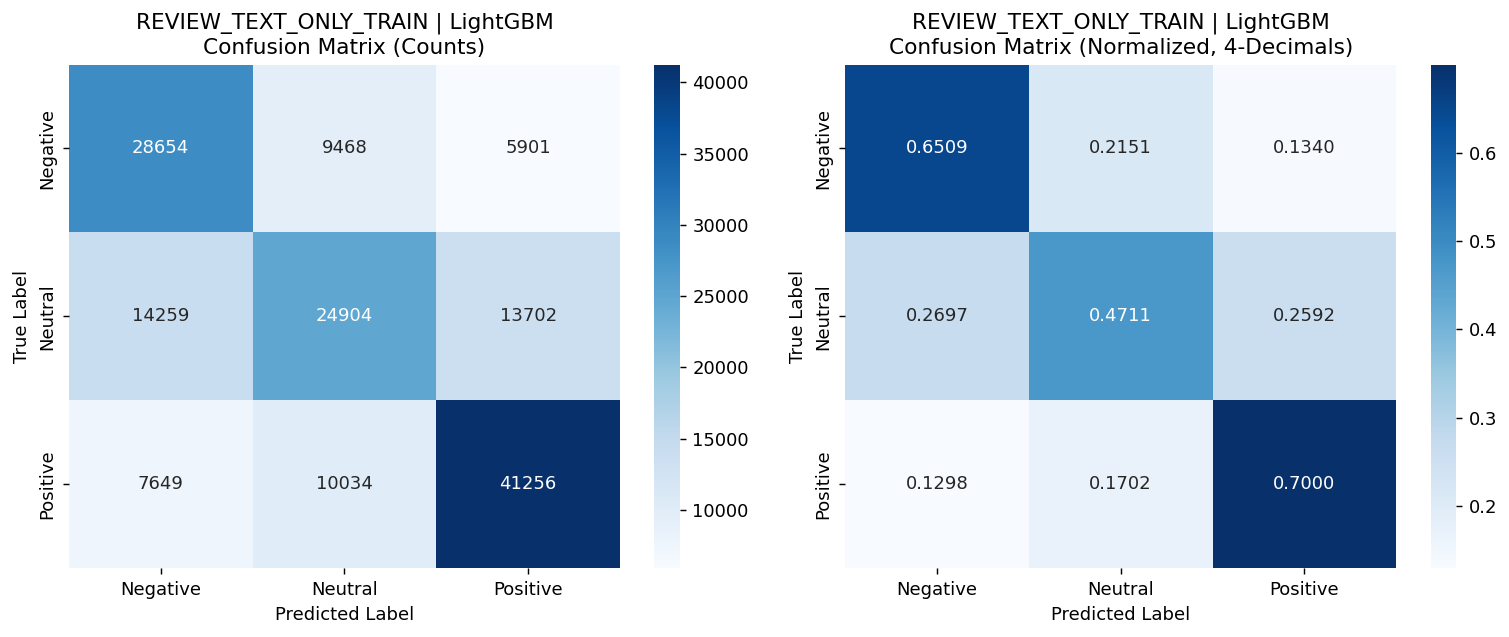


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.5667  Recall=0.6509  F1=0.6059  Support=44023
Neutral   : Precision=0.5608  Recall=0.4711  F1=0.5121  Support=52865
Positive  : Precision=0.6779  Recall=0.7000  F1=0.6888  Support=58939

TEST SET PERFORMANCE

[REVIEW_TEXT_ONLY_TEST | LightGBM]
Accuracy=0.5638  F1_weighted=0.5607  Precision_weighted=0.5611  Recall_weighted=0.5638

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.5223    0.6003    0.5586     11006
     Neutral     0.4898    0.4172    0.4506     13216
    Positive     0.6540    0.6681    0.6610     14735

    accuracy                         0.5638     38957
   macro avg     0.5554    0.5619    0.5567     38957
weighted avg     0.5611    0.5638    0.5607     38957



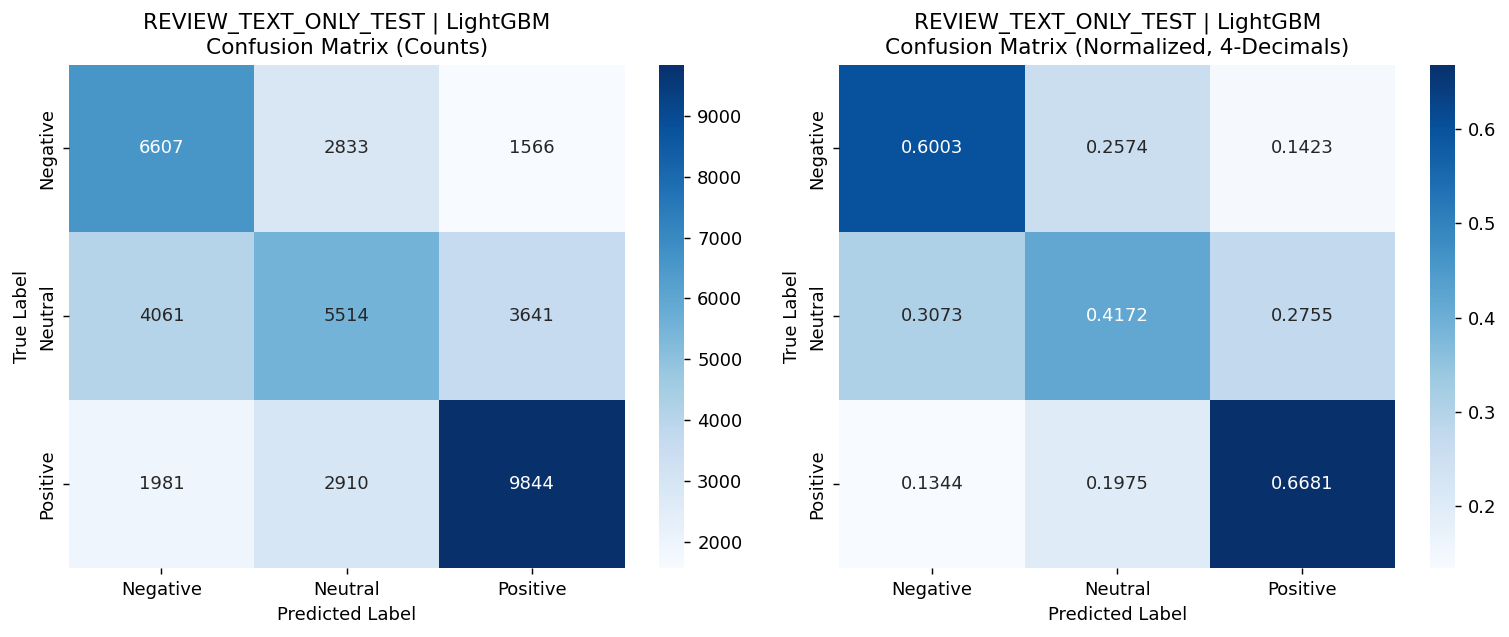


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.5223  Recall=0.6003  F1=0.5586  Support=11006
Neutral   : Precision=0.4898  Recall=0.4172  F1=0.4506  Support=13216
Positive  : Precision=0.6540  Recall=0.6681  F1=0.6610  Support=14735

✅ Model saved to: /kaggle/working/LightGBM_Multiclass/REVIEW_TEXT_ONLY/LightGBM_REVIEW_Multiclass.pkl


In [8]:
# ======================================================================
# LIGHTGBM — REVIEW TEXT ONLY (Review Text TF-IDF)
# ======================================================================

setup = "REVIEW_TEXT_ONLY"
save_dir = os.path.join(BASE_SAVE_DIR, setup)
os.makedirs(save_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"LIGHTGBM — REVIEW TEXT ONLY")
print(f"{'='*70}")

# ---- DEFINING PARAMS LOCALLY (So this cell is independent) ----
lgb_params_review = {
    'objective': 'multiclass',
    'num_class': N_CLASSES,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    
    # Model Complexity
    'max_depth': 4,
    'num_leaves': 15,  
    'learning_rate': 0.1,
    
    # Regularization & Sampling
    'bagging_fraction': 0.8, # subsample
    'bagging_freq': 1,
    'feature_fraction': 0.8, # colsample_bytree
    'min_child_weight': 10,
    'lambda_l1': 0.5, # reg_alpha
    'lambda_l2': 2.0, # reg_lambda
    
    # SWITCH TO CPU FOR STABILITY WITH SPARSE DATA
    'device': 'cpu', 
    'n_jobs': -1,  # Use all available Kaggle CPU cores
    
    'seed': RNG,
    'verbose': -1
}

# Use only review text features
# We assume Xtr_review and Xte_review exist from Part 4
X_train_REVIEW = Xtr_review
X_test_REVIEW = Xte_review

print(f"X_train_REVIEW shape: {X_train_REVIEW.shape}")
print(f"X_test_REVIEW shape: {X_test_REVIEW.shape}")

# Create LightGBM Dataset
print("Creating LightGBM Datasets...")
sample_weights_train = np.array([class_weight_dict[label] for label in y_train])
train_data_review = lgb.Dataset(X_train_REVIEW, label=y_train, weight=sample_weights_train)
test_data_review = lgb.Dataset(X_test_REVIEW, label=y_test, reference=train_data_review)

# ---- K-FOLD CROSS-VALIDATION ----
print("\nRunning 5-Fold Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
cv_scores_review = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_REVIEW, y_train), 1):
    X_tr_fold = X_train_REVIEW[tr_idx]
    X_val_fold = X_train_REVIEW[val_idx]
    y_tr_fold = y_train[tr_idx]
    y_val_fold = y_train[val_idx]
    
    w_tr_fold = np.array([class_weight_dict[label] for label in y_tr_fold])
    
    dtrain_fold = lgb.Dataset(X_tr_fold, label=y_tr_fold, weight=w_tr_fold)
    dval_fold = lgb.Dataset(X_val_fold, label=y_val_fold, reference=dtrain_fold)
    
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=0) # Silence per-fold logs
    ]
    
    model_fold = lgb.train(
        lgb_params_review, # Using local independent params
        dtrain_fold,
        num_boost_round=1000,
        valid_sets=[dtrain_fold, dval_fold],
        callbacks=callbacks
    )
    
    # Predict
    y_pred_prob_fold = model_fold.predict(X_val_fold)
    y_pred_fold = np.argmax(y_pred_prob_fold, axis=1)
    
    acc = accuracy_score(y_val_fold, y_pred_fold)
    f1 = precision_recall_fscore_support(y_val_fold, y_pred_fold, average='weighted', zero_division=0)[2]
    cv_scores_review.append((acc, f1))
    print(f"  Fold {fold}: acc={acc:.4f} | f1_weighted={f1:.4f}")

cv_arr_review = np.array(cv_scores_review)
print(f"  LightGBM (Review Text Only) CV mean±std | acc={cv_arr_review[:,0].mean():.4f}±{cv_arr_review[:,0].std():.4f} f1_w={cv_arr_review[:,1].mean():.4f}±{cv_arr_review[:,1].std():.4f}")

# ---- FIT ON FULL TRAIN ----
print("\nTraining on full training set...")
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100)
]

lgb_review = lgb.train(
    lgb_params_review, 
    train_data_review, 
    num_boost_round=1000, 
    valid_sets=[train_data_review, test_data_review], 
    valid_names=['train', 'test'], 
    callbacks=callbacks
)

# ---- PREDICTIONS ----
print("\nMaking predictions...")
train_prob_review = lgb_review.predict(X_train_REVIEW)
train_pred_review = np.argmax(train_prob_review, axis=1)

test_prob_review = lgb_review.predict(X_test_REVIEW)
test_pred_review = np.argmax(test_prob_review, axis=1)

# ---- EVALUATION ----
print(f"\n{'='*70}")
print("TRAIN SET PERFORMANCE")
print(f"{'='*70}")
train_metrics_review = evaluate_and_plot(
    "LightGBM", f"{setup}_TRAIN", y_train, train_prob_review, train_pred_review, save_dir
)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE")
print(f"{'='*70}")
test_metrics_review = evaluate_and_plot(
    "LightGBM", f"{setup}_TEST", y_test, test_prob_review, test_pred_review, save_dir
)

# ---- SAVE MODEL ----
model_path_review = os.path.join(save_dir, "LightGBM_REVIEW_Multiclass.pkl")
with open(model_path_review, "wb") as f:
    pickle.dump({
        "model": lgb_review,
        "tfidf_review": tfidf_review,
        "class_names": class_names,
        "class_weight_dict": class_weight_dict,
        "lgb_params": lgb_params_review,
        "feature_set": "Review Text Only"
    }, f)

print(f"\n✅ Model saved to: {model_path_review}")